<a href="https://colab.research.google.com/github/winirrr/Thai-qoute-generator/blob/main/model/finetuned_model_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q auto-gptq optimum bitsandbytes accelerate peft evaluate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.0/410.0 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

## Prepare Model for Training

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from transformers import TrainingArguments, Trainer
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import transformers
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model_name = "scb10x/typhoon-7b"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    trust_remote_code=False,
    quantization_config=bnb_config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.57G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/563k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.99M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
model.train() # model in training mode (dropout modules are activated)

# enable gradient check pointing
model.gradient_checkpointing_enable()

# enable quantized training
model = prepare_model_for_kbit_training(model)

In [ ]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 21,286,040 || all params: 7,289,388,184 || trainable%: 0.29201408215194596


## Prepare Training Dataset

In [ ]:
dataset = load_dataset("text", data_files="https://raw.githubusercontent.com/winirrr/Thai-qoute-generator/main/quote_data/900_small_th_qoute.txt", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['text'],
    num_rows: 900
})

In [ ]:
len(dataset)

900

In [ ]:
train_dataset = dataset
eval_dataset = dataset.shuffle(seed=42).select(range(int(len(dataset)*0.1)))

In [ ]:
train_dataset

Dataset({
    features: ['text'],
    num_rows: 900
})

In [ ]:
eval_dataset

Dataset({
    features: ['text'],
    num_rows: 90
})

In [ ]:
tk_data_1 = tokenizer(train_dataset['text'], padding=True, truncation=True, return_tensors='pt')
tk_data_2 = tokenizer(eval_dataset['text'], padding=True, truncation=True, return_tensors='pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
example_tk = tokenizer("อยู่หน้าจอทั้งวัน มันไม่ดีหรอก มาอยู่ในใจเราดิ ดีกว่าเยอะ",padding=True, truncation=True, return_tensors='pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
example_tk

{'input_ids': tensor([[    1, 34264, 32170, 33625, 32227, 32123, 33300, 32062, 32109, 32117,
         32071, 32636, 32815, 32146, 32262, 33005, 33298, 32320, 33667,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data['input_ids']
        self.attention_mask = data['attention_mask']
        self.labels = data['input_ids']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels':self.labels[idx]
        }

train_data = CustomDataset(tk_data_1)
eval_data = CustomDataset(tk_data_2)

## Fine-tuning the Model

In [ ]:
output_dir = './typhoon-7b-quote-demo'

# hyperparameters
lr = 2e-4
batch_size = 3
num_epochs = 14

# define training arguments
training_args = TrainingArguments(
    output_dir= output_dir,
    learning_rate=lr,
    #max_steps=1000,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=4,
    warmup_steps=1,
    fp16=True,
    optim="paged_adamw_8bit",
    do_eval=True,
)

model.config.use_cache = False

In [ ]:
# data collator
data_collator = transformers.DataCollatorForLanguageModeling(tokenizer,
                                                              mlm=False)

# configure trainer
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    args=training_args,
    data_collator=data_collator
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
import warnings

# Filter out the specific warning about torch.utils.checkpoint
warnings.filterwarnings("ignore", message="torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly.*")


# train model
model.config.use_cache = False  # silence the warnings.
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.798700,1.760162
2,1.648200,0.935521
3,0.920000,0.640151
4,0.717300,0.591235
5,0.650500,0.535924
6,0.603700,0.546244
7,0.567600,0.501930
8,0.543400,0.475640
9,0.519800,0.465130
10,0.499700,0.452609


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

TrainOutput(global_step=1050, training_loss=0.8077419753301711, metrics={'train_runtime': 7072.1519, 'train_samples_per_second': 1.782, 'train_steps_per_second': 0.148, 'total_flos': 1.6745329386576e+16, 'train_loss': 0.8077419753301711, 'epoch': 14.0})

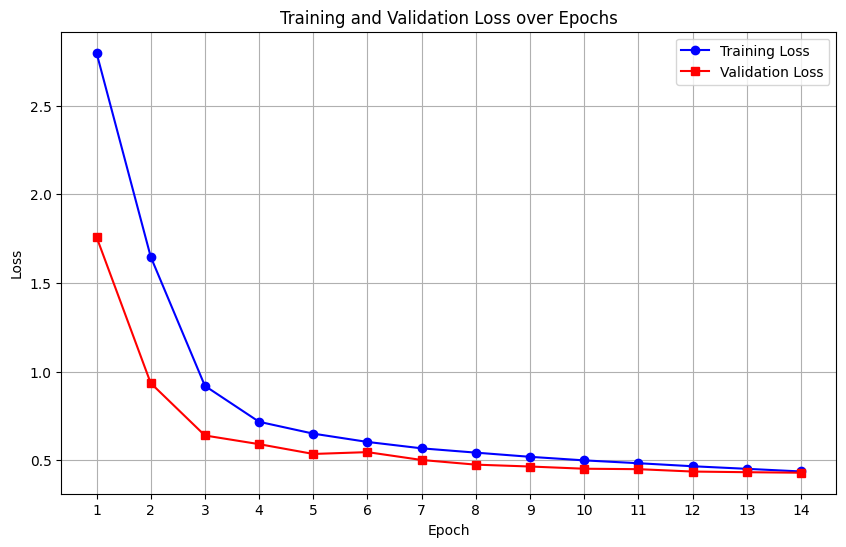

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(epoch_list, training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, training_losses, label='Training Loss', marker='o', color='b')
    plt.plot(epoch_list, validation_losses, label='Validation Loss', marker='s', color='r')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epoch_list)  # Set x-axis ticks to be the epoch numbers
    plt.legend()
    plt.grid(True)
    plt.show()


epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
training_losses = [2.7987, 1.6482, 0.92, 0.7173, 0.6505, 0.6037, 0.5676, 0.5434, 0.5198, 0.4997, 0.4837, 0.4666, 0.4521, 0.4372]
validation_losses = [1.760162, 0.935521, 0.640151, 0.591235, 0.535924, 0.546244, 0.50193, 0.47564, 0.46513, 0.452609, 0.450167, 0.436748, 0.433028, 0.430109]

# Call the function to plot
plot_losses(epochs, training_losses, validation_losses)

In [ ]:
model.config.use_cache = True

## Inference

In [ ]:
prompt = "รัก"

inputs = tokenizer(prompt, return_tensors="pt")

model.eval()
with torch.inference_mode():
 outputs = model.generate(**inputs, penalty_alpha=0.6, top_k=4)
 print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

NameError: name 'tokenizer' is not defined

## Push our model into hugging face

In [ ]:
from huggingface_hub import notebook_login

notebook_login()
model.push_to_hub("winirrr/typhoon-7b-quote-demoV1")

adapter_model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/winirrr/typhoon-7b-quote-demoV1/commit/5c07981c338fa552582977b39a8905b3279118f2', commit_message='Upload model', commit_description='', oid='5c07981c338fa552582977b39a8905b3279118f2', pr_url=None, pr_revision=None, pr_num=None)